# 1-Preprocessing

In this notebook, I import the movie-review dataset, clean it, and write the results to a pair of CSV files.

## Import

In [287]:
import matplotlib.pyplot as plt
import pandas as pd
import re

from nltk import PorterStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

from string import punctuation
from datasets import load_dataset

## Load IMDB Dataset

In [24]:
ds = load_dataset('imdb')
train, test = pd.DataFrame(ds['train']), pd.DataFrame(ds['test'])

In [26]:
train.sample(5)

,text,label
21255,This is one of the greatest sports movies ever...,1
23770,This is your typical cheerful and colorful MGM...,1
14887,"This show is quick-witted, colorful, dark yet ...",1
16021,"Drum scene is wild! Cook, Jr. is unsung hero o...",1
11327,Every once in a while I will rent an action/ad...,0


In [27]:
test.sample(5)

,text,label
23755,An especially delightful film to those of us w...,1
18697,My favourite story from 'tales from the crypt'...,1
17669,"Stalingrad is a terrific movie, well acted and...",1
16365,This film was adapted from the well known sutr...,1
9347,A couple of clarifying comments are in order. ...,0


## EDA

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


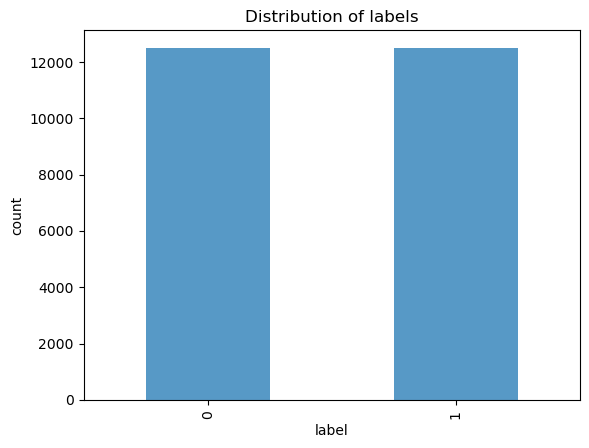

In [62]:
fig, ax = plt.subplots()
train.groupby('label').count().plot(kind='bar', alpha=0.75, ax=ax)
ax.set_ylabel('count')
ax.set_title('Distribution of labels')
ax.legend().set_visible(False)
plt.show()

In [65]:
thumbs_ups = train[train['label'] == 1]
thumbs_downs = train[train['label'] == 0]

In [154]:
ex0 = thumbs_ups['text'].sample().to_list()
ex0

['The whole does not even come close to the sum of the parts. No problem. This film features a line-up of some of the most diversely creative directors of our time and some really famous names in the cast. The segments are devised around the same theme, "Love in Paris", but the resemblance ends there. Actually, considering that the approach to the theme from all these different directors takes so many forms, it is amazing that we can even feel we are still watching the same film. No great effort has been made to turn it into a comprehensive whole. This buffet has so many great ingredients, I am glad nobody tried to put them all in a single dish.']

In [181]:
ex1 = thumbs_downs['text'].sample().to_list()
ex1

['I was curious to watch this movie. A lot of people seem to be excited. I also have my beliefs. I believe in Jesus Christ but I\'m opened for any kind of views or opinions. It doesn\'t matter for me, if Jesus existed in the way it\'s written in the bible. If Maria was a virgin or not, or all the other similar pagan coincidences. What matters for me is the idea of salvation, the idea of love as the only way to find peace in this world.<br /><br />What made me angry is when somebody takes a sentence, present it as a fact but without showing the context it was written. For example, they showed in this movie following sentence big: "Those enemies of mine who did not want me to be king over them - bring them here and kill them in front of me" Jesus (Lukas 19:27) What they didn\'t tell you is the context. Jesus told a story about an evil king. There is no passage in the bible where Jesus supports killing. He is love! After quoting the bible wrong they present us yelling people (pseudo-chris

## Preprocessor

In [236]:
class Preprocessor(BaseEstimator, TransformerMixin):
    @staticmethod
    def strip_html(X):
        return [re.sub(r'<[^>]+>', ' ', doc) for doc in X]

    @staticmethod
    def strip_forward_slashes(X):
        return [doc.replace('/', ' ') for doc in X]

    @staticmethod
    def strip_punctuation(X):
        def strip_punc_from_doc(doc: str) -> str:
            return_val = doc
            for p in punctuation:
                return_val = return_val.replace(p, '')
            return return_val
        return [strip_punc_from_doc(doc) for doc in X] 

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = X.to_list()
            
        X_trans = X
        X_trans = [doc.lower() for doc in X_trans]
        X_trans = Preprocessor.strip_html(X_trans)
        X_trans = Preprocessor.strip_forward_slashes(X_trans)
        X_trans = Preprocessor.strip_punctuation(X_trans)
        
        return X_trans

In [237]:
preprocessor = Preprocessor()

In [238]:
docs = train['text']
docs_trans = preprocessor.transform(docs)

In [239]:
docs_trans[4]

'oh brotherafter hearing about this ridiculous film for umpteen years all i can think of is that old peggy lee song  is that all there is i was just an early teen when this smoked fish hit the us i was too young to get in the theater although i did manage to sneak into goodbye columbus then a screening at a local film museum beckoned  finally i could see this film except now i was as old as my parents were when they schlepped to see it  the only reason this film was not condemned to the anonymous sands of time was because of the obscenity case sparked by its us release millions of people flocked to this stinker thinking they were going to see a sex filminstead they got lots of closeups of gnarly repulsive swedes onstreet interviews in bland shopping malls asinie political pretensionand feeble whocares simulated sex scenes with saggy pale actors  cultural icon holy grail historic artifactwhatever this thing was shred it burn it then stuff the ashes in a lead box  elite esthetes still sc

## Tokenizer

In [267]:
class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, stemmer, stop_words=None):
        self.stemmer = stemmer
        self.stop_words = stop_words

    def remove_stop_words(self, X):
        def remove_stop_words_from_doc(doc):
            return_doc = []
            for word in doc:
                if word not in self.stop_words:
                    return_doc.append(word)
            return return_doc
        return [remove_stop_words_from_doc(doc) for doc in X]

    def stem(self, X):
        def stem_doc(doc):
            return_doc = []
            for word in doc:
                return_doc.append(self.stemmer.stem(word))
            return return_doc
        return [stem_doc(doc) for doc in X]
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = X.to_list()
            
        X_trans = X
        X_trans = [doc.split() for doc in X_trans]
        X_trans = self.remove_stop_words(X_trans)
        X_trans = self.stem(X_trans)
        X_trans = [' '.join(doc) for doc in X_trans]
        
        return X_trans

In [268]:
tokenizer = Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)

In [269]:
docs = tokenizer.transform(docs_trans[0:1])

In [270]:
print(docs[0])

rent curiousyellow video store controversi surround releas 1967 heard seiz custom tri enter countri fan film consid controversi realli plot center young swedish drama student name lena want learn life particular want focu attent make sort documentari averag swede thought certain polit issu vietnam war race issu unit state ask politician ordinari denizen stockholm opinion polit sex drama teacher classmat marri men kill curiousyellow 40 year ago consid pornograph realli sex nuditi scene far shot like cheapli porno countrymen mind shock realiti sex nuditi major stapl swedish cinema ingmar bergman arguabl answer good old boy john ford sex scene film commend filmmak fact sex shown film shown artist purpos just shock peopl make money shown pornograph theater america curiousyellow good film want studi meat potato pun intend swedish cinema realli film doesnt plot


## Pipeline

In [280]:
tokenizer = Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)

vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=750
)

random_forest_classifier = RandomForestClassifier()

pipe = Pipeline([
    ('preprocessor', Preprocessor()),
    ('tokenizer', tokenizer),
    ('vectorizer', vectorizer),
    ('classifier', random_forest_classifier)
])

In [290]:
X_train, X_test, y_train, y_test =\
    train['text'], test['text'], train['label'], test['label']

In [291]:
result = pipe.fit(X_train, y_train)

In [292]:
y_pred = result.predict(X_test)
f1_score(y_test, y_pred)

0.8258982396913431